After running dopseq region pipeline, we can explore which chromosomes are enriched with positions. 

In [23]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np
from matplotlib import pyplot
from scipy.stats import binom_test

import warnings
warnings.filterwarnings('ignore')

In [24]:
# take all samples processed with dopseq
REGS = glob.glob('../results/8_regions/*tsv')
# we also need chromosome sizes
GENOME_FAI = '../genome/genome.fa.fai'

In [25]:
#import all data into one dataframe, merging multiple regions per chromosome and 
# calculating log-ratios and p-values for position enrichment
list_ = []
for file_ in REGS:
    df = pd.read_csv(file_, sep='\t', header=0)
    cg = df.groupby('chrom')
    df2 = pd.concat([cg[['sample','chrom_len']].first(),
                     cg[['reg_pos', 'reg_reads', 'pos_len_sum', 'reg_len']].sum(),
                     cg[['pd_mean', 'pos_cov_mean', 'pos_len_mean']].mean(),
                     cg[['reg_start']].min(),
                     cg[['reg_end']].max()],
                    axis=1).set_index(["sample"], append = True)
    # summary stats for sample
    total_pos = df2['reg_pos'].sum()
    genome_len = df2['chrom_len'].sum()
    # log ratio for position enrichment
    df2['log_ratio'] = np.log10( (df2['reg_pos'] / total_pos) / (df2['chrom_len'] / genome_len) )
    # position enrichment p-value
    df2['p_value'] = df2.apply(lambda row: binom_test(row['reg_pos'],  total_pos,
                                               row['chrom_len'] / genome_len, 
                                               alternative='greater'), axis=1)
    list_.append(df2)
frame = pd.concat(list_)
del list_
frame = frame.sort_index()
frame.head(12)

chrom_len  reg_pos  reg_reads  pos_len_sum    reg_len  \
chrom sample                                                          
1     A       122678785      392        836        13810  122678785   
      B       122678785        7          9          492  122678785   
      C       122678785       45         52         3912  122678785   
10    A        69331447      226        556         9257   69331447   
      B        69331447       10         20          610   69331447   
      C        69331447       27         32         2183   69331444   
11    A        74389097      231        515         8435   74389097   
      B        74389097        4          6          243   74389097   
      C        74389097       32         37         2343   74389097   
12    A        72498081      257        576        11294   72498079   
      B        72498081        4         56          284   72498081   
      C        72498081       44         77         3909   72498079   

                   pd_mean  pos_cov_mean  pos_len_mean  reg_start    reg_end  \
chrom sample                                                                   
1     A       1.343074e+05      2.132653     35.229592          0  122678785   
      B       9.244853e+06      1.285714     70.285714          0  122678785   
      C       1.022116e+06      1.155556     86.933333          0  122678785   
10    A       9.689469e+04      2.460177     40.960177          0   69331447   
      B       2.601357e+06      2.000000     61.000000          0   69331447   
      C       1.181252e+06      1.165179     78.664286          0   69331447   
11    A       1.115578e+05      2.229437     36.515152          0   74389097   
      B       1.533557e+07      1.500000     60.750000          0   74389097   
      C       7.128530e+05      1.156250     73.218750          0   74389097   
12    A       9.332755e+04      2.035160     62.169169          0   72498081   
      B       4.411639e+06     14.000000     71.000000          0   72498081   
      C       1.279180e+06      2.125356     78.376068          0   72498081   

              log_ratio   p_value  
chrom sample                       
1     A       -0.055596  0.996244  
      B       -0.766194  1.000000  
      C       -0.359360  1.000000  
10    A       -0.046935  0.955508  
      B       -0.363453  0.999333  
      C       -0.333369  0.999999  
11    A       -0.068010  0.993844  
      B       -0.791972  1.000000  
      C       -0.290162  0.999994  
12    A       -0.010506  0.661667  
      B       -0.780789  1.000000  
      C       -0.140677  0.990697

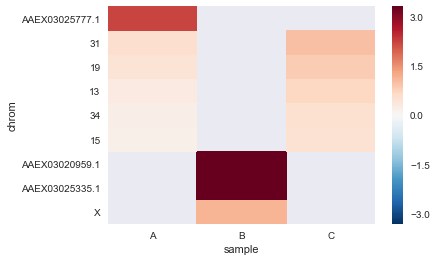

In [26]:
# subset signigicantly enriched samples, correcting threshold p-value by the number of observations
sf = frame[frame['p_value'] < (0.05 / frame.shape[0])]
sns.heatmap(sf['log_ratio'].unstack().sort_values(['A','B','C'], ascending=False), center=0);